# Abandoned Variation of the Model
### Using columns that are found to be reducing the validation accuracy. Please refer to section II of the report.
This model contains 'hour', 'holiday', 'num_tokens', count_all_caps', 'excl_quest' and 'positivity' columns (with ~62 val. acc. compared to 63% of the finalized model)
## Important: This is NOT the finalized model. Please refer to finalized_model.ipynb for the finalized model.

In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import tqdm
import matplotlib.pyplot as plt
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import seaborn as sns
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
ps = PorterStemmer()
import spacy
nlp = spacy.load('en_core_web_sm')
import warnings
warnings.filterwarnings("ignore")

In [2]:
def load_data(split_name):
    df = pd.read_csv(f'data_2021_spring/{split_name}.csv')
    print('loading data:',split_name,'\t length:',len(df))
    return df

def lower(s):
    if isinstance(s, list):
        return [lower(t) for t in s]
    if isinstance(s, str):
        return s.lower()
    else:
        raise NotImplementedError("unknown datatype")

def tokenize(text):
    return nltk.word_tokenize(text)

def stem(tokens):
    return [ps.stem(token) for token in tokens]

def n_gram(tokens, n=1):
    if n == 1:
        return tokens
    else:
        results = list()
        for i in range(len(tokens)-n+1):
            # tokens[i:i+n] will return a sublist from i th to i+n th (i+n th is not included)
            results.append(" ".join(tokens[i:i+n]))
        return results

def filter_stopwords(tokens):
    return [token for token in tokens if token not in stopwords and not token.isnumeric()]

def get_onehot_vector(feats, feats_dict):
    # initialize the vector as all zeros
    vector = np.zeros(len(feats_dict), dtype=np.float)
    for f in feats:
        # get the feature index, return -1 if the feature is not existed
        f_idx = feats_dict.get(f, -1)
        if f_idx != -1:
            # set the corresponding element as 1
            vector[f_idx] = 1
    return vector

def tfidf_tokenizer(text):   
    tokens = nltk.word_tokenize(text) # tokenize
    tokens = [token for token in tokens if token not in stopwords and not token.isnumeric()] # filter stopword
    stemmed = [ps.stem(token) for token in tokens]  # stem  
    return list(map(lambda x: lower(x), stemmed)) # lower

def tfidf_tokenizer_1(text):   
    tokens = nltk.word_tokenize(text) # tokenize
    return tokens

def tfidf_tokenizer_2(tokens):
    tokens = [token for token in tokens if token not in stopwords and not token.isnumeric()] # filter stopword
    stemmed = [ps.stem(token) for token in tokens]  # stem  
    return list(map(lambda x: lower(x), stemmed)) # lower

def isAdj(token):
    for token in nlp(token):
        return token.pos_ == 'ADJ'

def get_unla(tokens): # un-stem, non-stop, lower-case adjectives
    tokens = [token for token in tokens if token not in stopwords and not token.isnumeric()] # filter stopword
    tokens = [token for token in tokens if isAdj(token)] # get adjectives only
    return list(map(lambda x: lower(x), tokens))

def list_all_caps(tokens):
    new_list = []
    for token in tokens:
        if token.isalpha() and token.upper() == token and token.upper() not in ['I','A']:
            new_list.append(token.lower())
    return new_list

def count_tokens(tokens):
    return len(tokens)

def count_excl_quest(tokens):
    count = 0
    for token in tokens:
        if token == '!' or token == '?':
            count += 1
    return count

In [3]:
def get_new_df(mode):
    df = load_data(mode)
    
    # Change the type from str to dt
    df['date'] = pd.to_datetime(df['date'], errors='ignore')
    
    # Getting the day of the week {0: Monday, 1:Tuesday,...} base on the date
    df['day_of_week'] = df['date'].dt.weekday
    df['hour'] = df['date'].dt.hour
    
    # Getting if the date is the holiday (fed-holiday or sunday) (True to 1, False to 0)
    df['fed_holiday'] = df['date'].isin(calendar().holidays()).map({True: 1, False: 0})
    df['sunday'] = df['day_of_week'].isin([6]).map({True: 1, False: 0})
    df['holiday'] = df['sunday'] + df['fed_holiday']
    
    # Count the number of words, all-caps words, exclamation/question marks
    df['raw_tokens'] = df['text'].map(tfidf_tokenizer_1)
    df['tokens'] = df['raw_tokens'].map(tfidf_tokenizer_2)
    df['unla'] = df['raw_tokens'].map(get_unla) # un-stem, non-stop, lower-case adjectives
    df['num_tokens'] = df['tokens'].map(count_tokens)
    df['all_caps'] = df['raw_tokens'].map(list_all_caps)
    df['count_all_caps'] = df['all_caps'].map(len)
    df['excl_quest'] = df['tokens'].map(count_excl_quest)
    
    return df.drop(columns=['fed_holiday','sunday'])

In [4]:
train_df = get_new_df('train')
valid_df = get_new_df('valid')
test_df = get_new_df('test')

loading data: train 	 length: 10000
loading data: valid 	 length: 2000
loading data: test 	 length: 2000


In [5]:
def flatten_list(lists):
    new_list = []
    for one_list in lists:
        new_list += one_list
    return new_list

def prune_intersect(list1, list2):
    new_list1 = []
    new_list2 = []
    intersection = set(list1).intersection(set(list2))
    for element in list1:
        if element not in intersection:
            new_list1.append(element)
    for element in list2:
        if element not in intersection:
            new_list2.append(element)
    return new_list1, new_list2

def get_positivity(tokens):
    score = 0
    for token in tokens:
        if token in positivity_dict.keys():
            score += positivity_dict[token]
    return score

In [6]:
pos_list = flatten_list(list(train_df.loc[train_df['stars'] == 5]['unla']) + list(train_df.loc[train_df['stars'] == 4]['unla']))
neg_list = flatten_list(list(train_df.loc[train_df['stars'] == 1]['unla']) + list(train_df.loc[train_df['stars'] == 2]['unla']))
pos_list, neg_list = prune_intersect(pos_list, neg_list)

In [7]:
positivity_dict = dict()
for token in pos_list:
    positivity_dict[token] = positivity_dict.get(token, 0) + 1
for token in neg_list:
    positivity_dict[token] = positivity_dict.get(token, 0) - 1

In [8]:
train_df['positivity'] = train_df['unla'].map(get_positivity)
valid_df['positivity'] = valid_df['unla'].map(get_positivity)
test_df['positivity'] = test_df['unla'].map(get_positivity)

In [3]:
# start here to load processed data set directly, remember to import libraries first
train_df =  pd.read_csv('train_processed.csv')
valid_df =  pd.read_csv('valid_processed.csv')
test_df =  pd.read_csv('test_processed.csv')

In [4]:
train_text = train_df['tokens']
valid_text = valid_df['tokens']
test_text = test_df['tokens']

In [10]:
word2id = {}
for tokens in train_text:
    for token in tokens:
        if not token in word2id:
            word2id[token] = len(word2id)
word2id['<pad>'] = len(word2id)

In [5]:
train_df.corr().abs().style.background_gradient(cmap='coolwarm')

,Unnamed: 0,cool,funny,stars,useful,day_of_week,hour,holiday,num_tokens,count_all_caps,excl_quest,positivity
Unnamed: 0,1.000000,0.007653,0.005954,0.005002,0.006801,0.010415,0.024060,0.005766,0.013673,0.014646,0.006935,0.003693
cool,0.007653,1.000000,0.735803,0.087558,0.542500,0.032364,0.000334,0.014638,0.190484,0.036493,0.060244,0.041472
funny,0.005954,0.735803,1.000000,0.061346,0.507746,0.037347,0.009660,0.016810,0.228510,0.089075,0.095789,0.033298
stars,0.005002,0.087558,0.061346,1.000000,0.085296,0.009572,0.049565,0.017895,0.151242,0.135625,0.012370,0.282783
useful,0.006801,0.542500,0.507746,0.085296,1.000000,0.037780,0.015517,0.023228,0.245023,0.106921,0.080886,0.050560
day_of_week,0.010415,0.032364,0.037347,0.009572,0.037780,1.000000,0.004966,0.627325,0.027095,0.017169,0.000433,0.018868
hour,0.024060,0.000334,0.009660,0.049565,0.015517,0.004966,1.000000,0.021751,0.011070,0.014753,0.002500,0.025201
holiday,0.005766,0.014638,0.016810,0.017895,0.023228,0.627325,0.021751,1.000000,0.012200,0.018571,0.002211,0.005291
num_tokens,0.013673,0.190484,0.228510,0.151242,0.245023,0.027095,0.011070,0.012200,1.000000,0.380737,0.308776,0.089192
count_all_caps,0.014646,0.036493,0.089075,0.135625,0.106921,0.017169,0.014753,0.018571,0.380737,1.000000,0.287557,0.102229


In [12]:
tfidf = TfidfVectorizer(
            tokenizer = tfidf_tokenizer, 
            ngram_range=(1,4), 
            max_features= 150000, 
            min_df= 3,
            max_df= 0.9,
        )

In [13]:
# Building the tfidf vector using training set
train_tfidf = tfidf.fit_transform(train_df['text'])

# Transform the valid set and test set using the tfidf built by training set
valid_tfidf = tfidf.transform(valid_df['text'])
test_tfidf = tfidf.transform(test_df['text'])

In [14]:
train_tfidf.shape

(10000, 67282)

In [15]:
train_tfidf_array = train_tfidf.toarray()
valid_tfidf_array = valid_tfidf.toarray()
test_tfidf_array = test_tfidf.toarray()

In [16]:
train_tfidf_array.shape

(10000, 67282)

In [17]:
# Normalizing these columns of each dataset
train_df_copy = train_df.copy()
valid_df_copy = valid_df.copy()
test_df_copy = test_df.copy()

for column in ['funny', 'useful', 'cool', 'day_of_week','holiday','num_tokens','count_all_caps','excl_quest','positivity']:
    train_df_copy[column] = train_df_copy[column] /train_df_copy[column].abs().max()
    valid_df_copy[column] = valid_df_copy[column] /valid_df_copy[column].abs().max()
    test_df_copy[column] = test_df_copy[column] /test_df_copy[column].abs().max()

train_df = train_df_copy
valid_df = valid_df_copy
test_df = test_df_copy

In [6]:
### Stack up the numeric features for each dataset ###

f = train_df['funny'].values.reshape(-1, 1)
u = train_df['useful'].values.reshape(-1, 1)
# c = train_df['cool'].values.reshape(-1, 1)
# hr = train_df['hour'].values.reshape(-1, 1)
h = train_df['holiday'].values.reshape(-1, 1)
n = train_df['num_tokens'].values.reshape(-1, 1)
# a = train_df['count_all_caps'].values.reshape(-1, 1)
# e = train_df['excl_quest'].values.reshape(-1, 1)
p = train_df['positivity'].values.reshape(-1, 1)
train_numeric = np.hstack((f,u,h,n,p))

f = test_df['funny'].values.reshape(-1, 1)
u = test_df['useful'].values.reshape(-1, 1)
# c = test_df['cool'].values.reshape(-1, 1)
# hr = test_df['hour'].values.reshape(-1, 1)
h = test_df['holiday'].values.reshape(-1, 1)
n = test_df['num_tokens'].values.reshape(-1, 1)
# a = test_df['count_all_caps'].values.reshape(-1, 1)
# e = test_df['excl_quest'].values.reshape(-1, 1)
p = test_df['positivity'].values.reshape(-1, 1)
test_numeric = np.hstack((f,u,h,n,p))

f = valid_df['funny'].values.reshape(-1, 1)
u = valid_df['useful'].values.reshape(-1, 1)
# c = valid_df['cool'].values.reshape(-1, 1)
# hr = valid_df['hour'].values.reshape(-1, 1)
h = valid_df['holiday'].values.reshape(-1, 1)
n = valid_df['num_tokens'].values.reshape(-1, 1)
# a = valid_df['count_all_caps'].values.reshape(-1, 1)
# e = valid_df['excl_quest'].values.reshape(-1, 1)
p = valid_df['positivity'].values.reshape(-1, 1)
valid_numeric = np.hstack((f,u,h,n,p))

In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization, Activation, Input, Add, Concatenate, LayerNormalization
from tensorflow.keras import regularizers
from tensorflow.keras import metrics
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2

In [20]:
# Getting the labels
y_train = train_df['stars'].values -1
y_valid = valid_df['stars'].values -1

In [21]:
# Changing the labels to one hot vectors
y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)

In [2]:
class MyModel(tf.keras.Model):

#     def __init__(self, seq_length, vocab_size, embedding_size= 64):
    def __init__(self):
        super(MyModel, self).__init__()
#         self.embedding = layers.Embedding(output_dim=embedding_size, input_dim=vocab_size, input_length=seq_length)
        self.BiLSTM = layers.Bidirectional(
            layers.LSTM(10, return_sequences=False, dropout=0.5, 
                        recurrent_dropout=0.5, kernel_regularizer=l2(0.005), unit_forget_bias= True,
                       ), 
            merge_mode="ave"
        )
        self.dense1 = layers.Dense(64, activation='relu', kernel_regularizer=l2(0.005), bias_regularizer=l2(0.005))
        self.dense2 = layers.Dense(64, activation='relu', kernel_regularizer=l2(0.005), bias_regularizer=l2(0.005))
        self.dense3 = Dense(5, activation='softmax')
        self.nlp_dropout = Dropout(0.3)
        self.dropout = Dropout(0.5)
#         self.BN = BatchNormalization()
        self.LN = LayerNormalization()
        self.activation = Activation('relu')
        
    def call(self, inputs):
        nlp_input = inputs[0]
        numeric_input = inputs[1]
        nlp_input = tf.reshape(tensor= nlp_input, shape=(tf.shape(nlp_input)[0], 1, tf.shape(nlp_input)[-1]))
        nlp_input = self.BiLSTM(nlp_input)
        nlp_input = self.LN(nlp_input)
        nlp_input = self.nlp_dropout(nlp_input)
        x = layers.Concatenate()([nlp_input, numeric_input])
        x = self.dense1(x)
        x = self.dropout(x)
        x = self.activation(x)
        x = self.dense2(x)
        x = self.dropout(x)
        x = self.activation(x)
        x = self.dense3(x)
        
        return x

NameError: name 'tf' is not defined

In [53]:
os.makedirs("models", exist_ok=True)

# model = MyModel(seq_length = train_tfidf_array.shape[1] , vocab_size = len(word2id)+1 , embedding_size = 64)
model = MyModel()

model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate=5e-4),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models","weights.tf"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)

earlystopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=7,
    verbose=0)

def scheduler(epoch, lr):
    #if(epoch % 20 == 0 and epoch != 0):
    #    return lr * 0.5
    #return lr
    return lr * 0.97

scheduler = keras.callbacks.LearningRateScheduler(
    scheduler,
    verbose=0
)

np.random.seed(0)
tf.random.set_seed(0)

history = model.fit([train_tfidf_array, train_numeric], y_train,
                    validation_split=0.1,
                    epochs=40, batch_size=100, verbose=1,
                    callbacks=[checkpointer, earlystopping, scheduler])

#model.load_weights(os.path.join("models", "weights.tf"))

Epoch 1/40
90/90 [==============================] - 340s 1s/step - loss: 2.2428 - accuracy: 0.1822 - val_loss: 1.9543 - val_accuracy: 0.2440
Epoch 2/40
90/90 [==============================] - 93s 1s/step - loss: 1.9286 - accuracy: 0.2403 - val_loss: 1.8604 - val_accuracy: 0.2290
Epoch 3/40
90/90 [==============================] - 95s 1s/step - loss: 1.8421 - accuracy: 0.2580 - val_loss: 1.7942 - val_accuracy: 0.2480
Epoch 4/40
90/90 [==============================] - 102s 1s/step - loss: 1.7828 - accuracy: 0.2546 - val_loss: 1.7430 - val_accuracy: 0.2480
Epoch 5/40
90/90 [==============================] - 94s 1s/step - loss: 1.7327 - accuracy: 0.2925 - val_loss: 1.6982 - val_accuracy: 0.2960
Epoch 6/40
90/90 [==============================] - 93s 1s/step - loss: 1.6880 - accuracy: 0.3236 - val_loss: 1.6476 - val_accuracy: 0.4250
Epoch 7/40
90/90 [==============================] - 94s 1s/step - loss: 1.6391 - accuracy: 0.3730 - val_loss: 1.5837 - val_accuracy: 0.4540
Epoch 8/40
90/90 [

In [54]:
train_score = model.evaluate([train_tfidf_array, train_numeric], y_train,
                             batch_size=100)

test_score = model.evaluate([valid_tfidf_array, valid_numeric], y_valid,
                            batch_size=100)

print("training loss:", train_score[0], "training accuracy", train_score[1])
print("test loss:", test_score[0], "test accuracy", test_score[1])

20/20 [==============================] - 2s 84ms/step - loss: 1.0630 - accuracy: 0.6230
training loss: 0.6824794411659241 training accuracy 0.8646000027656555
test loss: 1.06300687789917 test accuracy 0.6230000257492065


In [55]:
#train_df.to_csv('train_processed.csv',mode='w+')
#test_df.to_csv('test_processed.csv',mode='w+')
#valid_df.to_csv('valid_processed.csv',mode='w+')

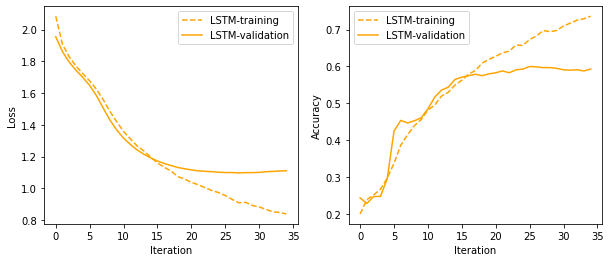

In [56]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="LSTM-training", color="orange", linestyle="dashed")
plt.plot(history.history["val_loss"], label="LSTM-validation", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="LSTM-training", color="orange", linestyle="dashed")
plt.plot(history.history["val_accuracy"], label="LSTM-validation", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [3]:
logits = model.predict([valid_tfidf_array, valid_numeric], batch_size=100)
# print(logits)
y_pred = np.argmax(logits, axis= -1)
y_true = valid_df['stars'] - 1
print(classification_report(y_true, y_pred))
conf = confusion_matrix(y_true, y_pred)
print(conf)

NameError: name 'model' is not defined

In [ ]:
sns.heatmap(conf, annot=True, cmap="YlGnBu")

# Use validation sets to evaluate

In [43]:
# Getting the prediction
logits = model.predict([valid_tfidf_array, valid_numeric], batch_size=100)
y_pred = np.argmax(logits, axis= -1) + 1

# Produce and export the ans and pred csv files 
val_ans = pd.DataFrame({'stars': valid_df['stars'], 'review_id': valid_df['review_id']})
val_pred = pd.DataFrame({'stars': y_pred, 'review_id': valid_df['review_id']})

val_ans.to_csv('./data/ans.csv', index= False)
val_pred.to_csv('./data/pred.csv', index=False)

In [44]:
%run evaluate.py

2000 2000 0
accuracy: 0.6195 	precision: 0.5834633525742616 	recall: 0.575463736599615 	f1: 0.5669521515223958


# Export test set prediction

In [ ]:
# Getting the prediction
logits = model.predict([test_tfidf_array, test_numeric], batch_size=100)
y_pred = np.argmax(logits, axis= -1) + 1

# Produce and export the ans and pred csv files 
test_pred = pd.DataFrame({'stars': y_pred, 'review_id': valid_df['review_id']})
test_pred.to_csv('./data/pred.csv', index=False)

In [ ]:
%run evaluate.py